# ALTEGRAD Challenge - Classification

*Abderrahim AIT-AZZI, Sébastien OHLEYER, Mickael SUTTON*

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search
import matplotlib.pyplot as plt
import os
import csv
from datetime import datetime
from log import _check_log_directory,_initialise_model_log

/Users/sebastienohleyer/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/sebastienohleyer/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
data_dir = "./data/"
log_dir = './log'

In [3]:
#initialize model directory
log_name = (datetime.now().strftime('%d-%m-%Y_%H-%M-%S'))
log_filepath = os.path.join(log_dir,log_name,'lighgb.csv')
_check_log_directory(os.path.join(log_dir,log_name))
_initialise_model_log(log_filepath)

Attempting to make log directory at ./log/06-02-2018_17-58-58


### Load data & features

In [4]:
from load_features import load_features

In [5]:
features_train, features_test, data_train = load_features(data_dir)

### Create train and test matrices

In [6]:
X_train= features_train.drop(['is_duplicate'],axis=1)
X_test = features_test
X_train=X_train.replace([np.inf, -np.inf], np.nan)
X_train=X_train.fillna(value=0)
X_test=X_test.replace([np.inf, -np.inf], np.nan)
X_test=X_test.fillna(value=0)
Y_train = data_train["is_duplicate"].values

In [7]:
X_train.columns

Index(['len_q1', 'len_q2', 'diff_len', 'len_char_q1', 'len_char_q2',
       'len_word_q1', 'len_word_q2', 'common_words', 'fuzz_qratio',
       'fuzz_WRatio',
       ...
       'num_g_q1', 'num_g_q2', 'num_o_q1', 'num_o_q2', 'num_k_q1', 'num_k_q2',
       'num_b_q1', 'num_b_q2', 'num_a_q1', 'num_a_q2'],
      dtype='object', length=155)

# Classifier LIGHTGB

In [8]:
from lgb_train import lgb_train

In [9]:
print('Number of features on train matrix: ',len(X_train.columns))
print('Number of features on test matrix: ',len(X_test.columns))

Number of features on train matrix:  155
Number of features on test matrix:  155


** Parameters**

In [14]:
RANDOM_SEED = 2017
lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'device': 'cpu',
        'feature_fraction': 0.486,
        'num_leaves': 140,
        'lambda_l2': 2,
        'learning_rate': 0.01,
        'num_boost_round': 5000,
        'early_stopping_rounds': 50,
        'max_depth': 25,
        'min_data_in_leaf': 15,
        'subsample': 1,
        'colsample_bytree': 1,
        'verbose': 1,
        'bagging_fraction_seed': RANDOM_SEED,
        'feature_fraction_seed': RANDOM_SEED,
    }

In [15]:
feat_imp = lgb_train(X_train, X_test, Y_train, lgb_params, log_filepath, test_prediction=True, num_folds=5)

/Users/sebastienohleyer/anaconda3/envs/nlp/lib/python3.6/site-packages/lightgbm/engine.py:98: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sebastienohleyer/anaconda3/envs/nlp/lib/python3.6/site-packages/lightgbm/engine.py:103: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 1: 1343 rounds, training loss 0.038273, validation loss 0.116772
Fold 2: 1285 rounds, training loss 0.039758, validation loss 0.122174
Fold 3: 1351 rounds, training loss 0.037464, validation loss 0.123156
Fold 4: 1548 rounds, training loss 0.032280, validation loss 0.121182
Fold 5: 1175 rounds, training loss 0.042675, validation loss 0.127786
Final CV val score: [0.11677176743495446, 0.12217407226347285, 0.12315616798829215, 0.12118221160648894, 0.12778599679406544]
Final mean CV val score: 0.12221404321745477

Make submission file...
Submission file written !


## Plot features importance

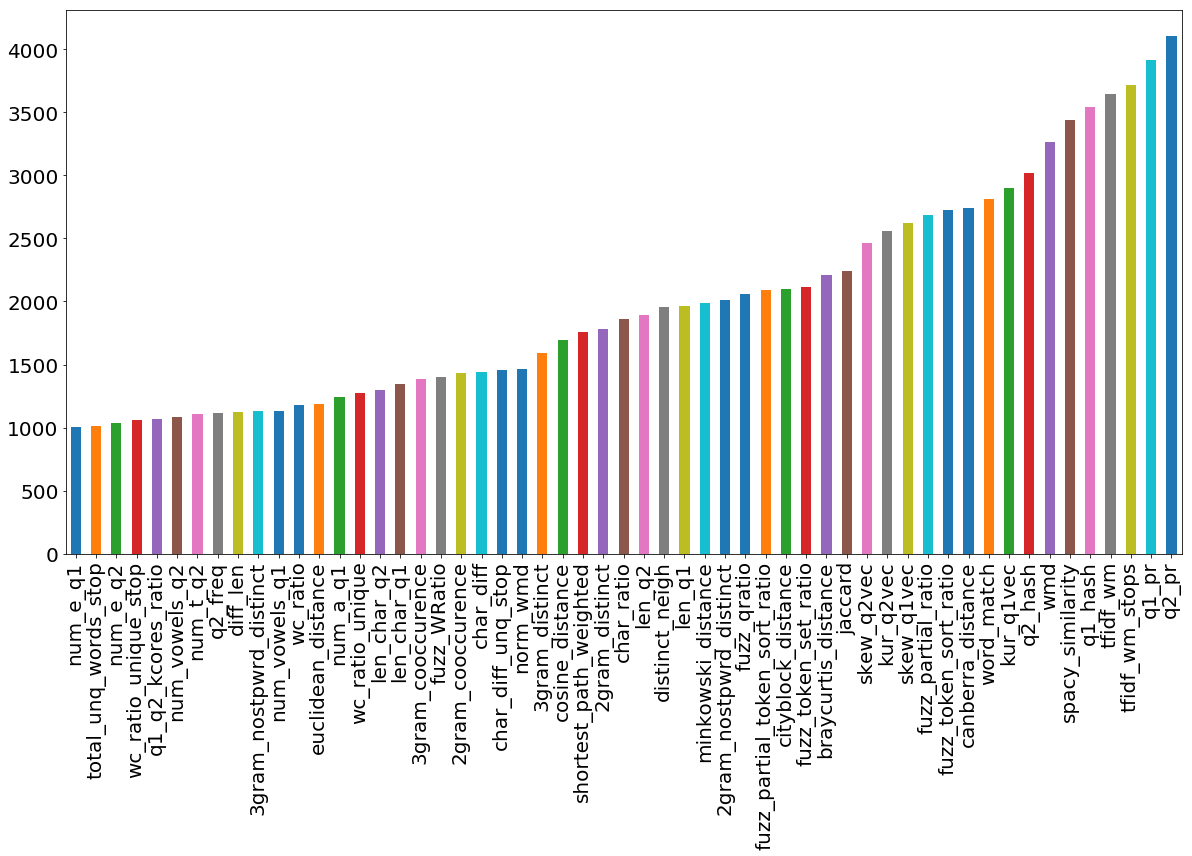

In [14]:
best_feat = feat_imp[feat_imp['importance']>1000]
plt.figure(figsize=(20,10))
ax = best_feat.importance.plot(kind='bar',use_index=False, fontsize=20)
ax.set_xticklabels(best_feat.column)
plt.savefig("feature_importance.eps", format='eps',bbox_inches='tight')

## Important note

The LighGB algorithm has several random initializations and unfortunately, we did not manage to completely fix them to be able to reproduce exactly a prediction. That is why you will not be able to replicate our best submission. We sincerely apologize for this problem.

However, note that with the provided code you will be able to reproduce every feature, run the classifier and achieve a result really close to our best submission (a random initialization set apart). We are at your disposal to answer any question you might have.